# Explore here

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv(r"D:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\LINEARREGRESSION\LinearRegressionProjectTutorial\data\raw\data.csv")

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.shape

(1338, 7)

In [5]:
#We check for duplicates
total_data = data.drop_duplicates().reset_index(drop = True)
total_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
data.shape

(1338, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


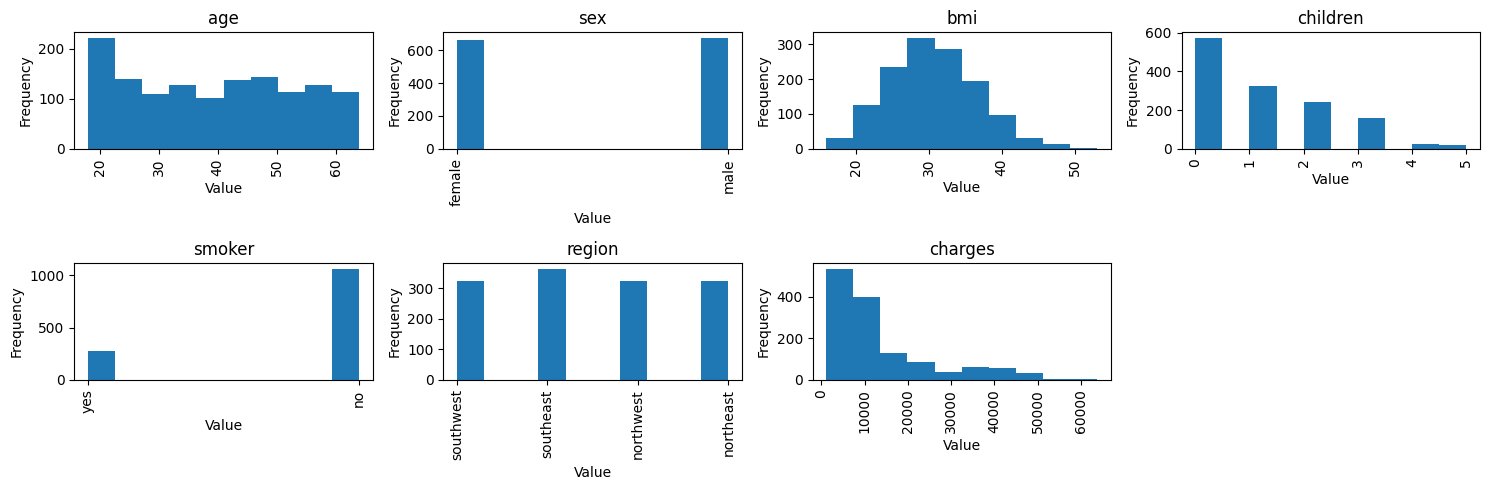

In [8]:
# We are going to visually display the different unique values and their ammounts into subplots.

# We generate the subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

axes_flat = axes.flatten()

# We iterate and plot histograms for each column.
for i, (ax, column) in enumerate(zip(axes_flat, data.columns)):
    ax.hist(data[column])
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)

for ax in axes_flat[len(data.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

The data reveals a clear majority of non-smokers and a balanced representation across regions and genders. The BMI distribution leans slightly right. Similarly, the number of children is right-skewed, with most having zero or few. The age distribution favors younger individuals, peaking around 20 years old.

We will now continue by transforming the data into numerical values.

In [9]:
def label_encode_columns(df, columns_to_encode):
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Dictionary to store encoding information
    encoding_dict = {}
    
    # Iterate over the specified columns
    for col in columns_to_encode:
            # Fit and transform the column
            df[col] = le.fit_transform(df[col].astype(str))
            
            # Store the encoding information in the dictionary
            encoding_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    return df, encoding_dict

columns_to_encode = ['sex', 'smoker', 'region']

encoded_df, encoding_info = label_encode_columns(total_data, columns_to_encode)

print(encoded_df.head())

print("Encoding Information:")
for col, encoding in encoding_info.items():
    print(f"\n{col}:")
    for original, encoded in encoding.items():
        print(f"  {original}: {encoded}")

   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520
Encoding Information:

sex:
  female: 0
  male: 1

smoker:
  no: 0
  yes: 1

region:
  northeast: 0
  northwest: 1
  southeast: 2
  southwest: 3


Region has four different values, we will use one hot encoding to generate two columns, one with "is_north" where northeast and northwest = 1 and the column "is_east" where northeast and southeast = 1.

In [10]:
total_data['region'].value_counts()

region
2    364
3    325
1    324
0    324
Name: count, dtype: int64

In [11]:
# We create new columns for north/south and east/west
total_data['is_north'] = total_data['region'].isin([0, 1]).astype(int)
total_data['is_east'] = total_data['region'].isin([0, 2]).astype(int)

total_data.drop('region', axis=1, inplace=True)

# We print the first few rows of the modified dataframe
print(total_data.head())

# We print the value counts for the new columns to verify the encoding
print("Value counts for 'is_north':")
print(total_data['is_north'].value_counts())
print("Value counts for 'is_east':")
print(total_data['is_east'].value_counts())

   age  sex     bmi  children  smoker      charges  is_north  is_east
0   19    0  27.900         0       1  16884.92400         0        0
1   18    1  33.770         1       0   1725.55230         0        1
2   28    1  33.000         3       0   4449.46200         0        1
3   33    1  22.705         0       0  21984.47061         1        0
4   32    1  28.880         0       0   3866.85520         1        0
Value counts for 'is_north':
is_north
0    689
1    648
Name: count, dtype: int64
Value counts for 'is_east':
is_east
1    688
0    649
Name: count, dtype: int64


In [12]:
total_data.head()

,age,sex,bmi,children,smoker,charges,is_north,is_east
0,19,0,27.900,0,1,16884.92400,0,0
1,18,1,33.770,1,0,1725.55230,0,1
2,28,1,33.000,3,0,4449.46200,0,1
3,33,1,22.705,0,0,21984.47061,1,0
4,32,1,28.880,0,0,3866.85520,1,0


Now that we have numerical values in our dataframe, we will proceed to split into training and testing data.

In [13]:
X = total_data.drop("charges", axis = 1)
y = total_data["charges"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
def minmax_scale_split_data(X_train, X_test, columns_to_scale):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Dictionary to store scaling information
    scaling_info = {}
    
    # Create copies of the input dataframes
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    # Iterate over the specified columns
    for col in columns_to_scale:
        # Fit the scaler on the training data and transform both train and test
        X_train_scaled[col] = scaler.fit_transform(X_train[[col]])
        X_test_scaled[col] = scaler.transform(X_test[[col]])
        
        # Store the scaling information in the dictionary
        scaling_info[col] = {
            'min': scaler.data_min_[0],
            'max': scaler.data_max_[0]
        }
    
    return X_train_scaled, X_test_scaled, scaling_info

# List of non-binary columns to scale
non_binary_columns = ['age', 'bmi', 'children']

# Apply MinMaxScaling
X_train_scaled, X_test_scaled, scaling_info = minmax_scale_split_data(X_train, X_test, non_binary_columns)

# Print the first few rows of the scaled training dataframe
print("Scaled Training Data:")
print(X_train_scaled.head())

print("Scaled Test Data:")
print(X_test_scaled.head())

print("Scaling Information:")
for col, info in scaling_info.items():
    print(f"{col}:")
    print(f"  Original Min: {info['min']}")
    print(f"  Original Max: {info['max']}")

Scaled Training Data:
           age  sex       bmi  children  smoker  is_north  is_east
1113  0.108696    1  0.230024       0.0       0         1        1
967   0.065217    1  0.263250       0.4       0         1        1
598   0.739130    0  0.580172       0.4       0         1        0
170   0.978261    1  0.686306       0.0       0         0        1
275   0.630435    0  0.286252       0.4       0         1        1
Scaled Test Data:
           age  sex       bmi  children  smoker  is_north  is_east
899   0.673913    1  0.176352       0.0       0         1        1
1063  0.239130    0  0.259349       0.8       0         0        0
1255  0.717391    0  0.549502       0.6       0         1        0
298   0.282609    1  0.495830       0.6       1         1        0
237   0.282609    1  0.603444       0.4       0         0        1
Scaling Information:
age:
  Original Min: 18.0
  Original Max: 64.0
bmi:
  Original Min: 15.96
  Original Max: 53.13
children:
  Original Min: 0.0
  Origina

We didn't scale the y, for it is the value we are aiming to predict.

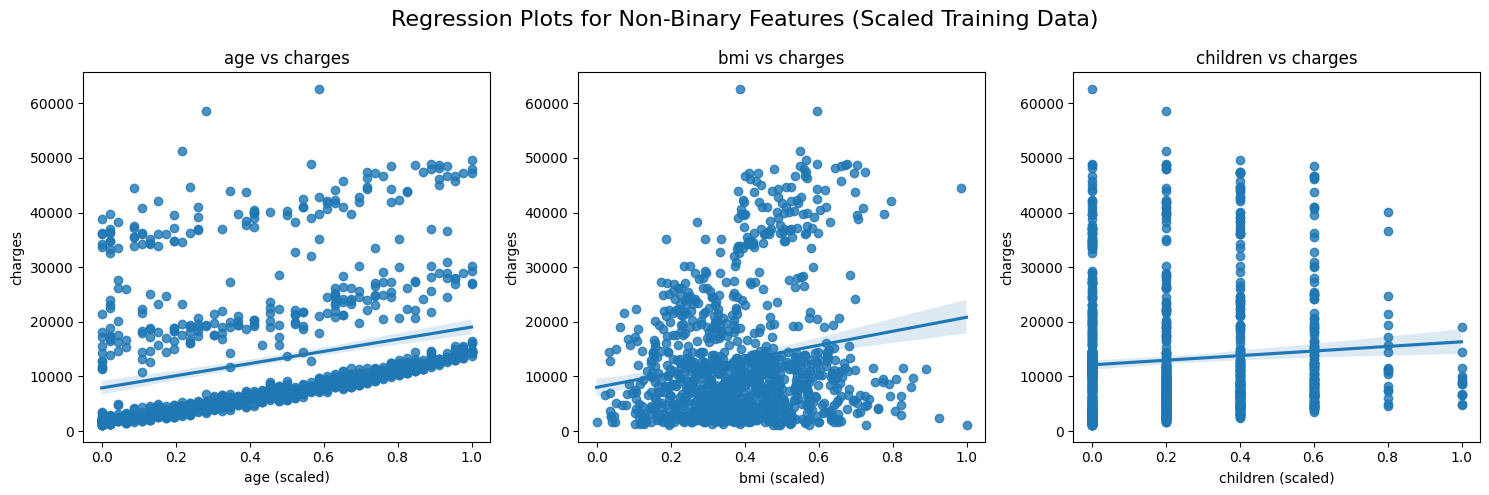

In [16]:
# We combine X_train_scaled and y_train into a single dataframe
df_train_scaled = pd.concat([X_train_scaled, y_train], axis=1)

# Define features and target
features = ['age', 'bmi', 'children']
target = 'charges'

# We create subplots
fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 5))
fig.suptitle('Regression Plots for Non-Binary Features (Scaled Training Data)', fontsize=16)

# Plot regplots for each feature
for i, feature in enumerate(features):
    sns.regplot(x=feature, y=target, data=df_train_scaled, ax=axes[i])
    axes[i].set_title(f'{feature} vs {target}')
    axes[i].set_xlabel(f'{feature} (scaled)')
    axes[i].set_ylabel(target)

plt.tight_layout()
plt.show()

In [17]:
# Define features and target
features = ['age', 'bmi', 'children']
target = 'charges'

# Initialize an empty list to store results
results_list = []

for feature in features:
    X = X_train_scaled[feature]
    y = y_train
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # Store the results
    results_list.append({
        'Feature': feature,
        'Coefficient': model.params[feature],
        'P-value': model.pvalues[feature],
        'R-squared': model.rsquared
    })

# Create summary dataframe from the list of results
summary_df = pd.DataFrame(results_list)

# Display the summary dataframe
print(summary_df)

    Feature   Coefficient       P-value  R-squared
0       age  11143.874987  4.099985e-22   0.083921
1       bmi  12829.960980  4.239224e-09   0.031841
2  children   4221.776153  4.811681e-03   0.007426


In [18]:
X = df_train_scaled['bmi']
y = df_train_scaled['charges']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     35.09
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           4.24e-09
Time:                        10:42:44   Log-Likelihood:                -11513.
No. Observations:                1069   AIC:                         2.303e+04
Df Residuals:                    1067   BIC:                         2.304e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7997.4810    919.788      8.695      0.0

In [19]:
X = df_train_scaled['age']
y = df_train_scaled['charges']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     97.75
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           4.10e-22
Time:                        10:42:44   Log-Likelihood:                -11484.
No. Observations:                1069   AIC:                         2.297e+04
Df Residuals:                    1067   BIC:                         2.298e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7894.7385    622.382     12.685      0.0

In [20]:
df_train_scaled.head()

,age,sex,bmi,children,smoker,is_north,is_east,charges
1113,0.108696,1,0.230024,0.0,0,1,1,2396.09590
967,0.065217,1,0.263250,0.4,0,1,1,3279.86855
598,0.739130,0,0.580172,0.4,0,1,0,33471.97189
170,0.978261,1,0.686306,0.0,0,0,1,13405.39030
275,0.630435,0,0.286252,0.4,0,1,1,9715.84100


In [21]:
target = 'charges'
features = [col for col in X_train_scaled.columns]

In [22]:
correlation_threshold = 0.06 
correlations = df_train_scaled.corr()[target].abs().sort_values(ascending=False)
selected_features = correlations[correlations > correlation_threshold].index.tolist()
selected_features.remove(target)

print("Correlations with target:")
for feature in selected_features:
    print(f"{feature}: {correlations[feature]:.4f}")

Correlations with target:
smoker: 0.7741
age: 0.2897
bmi: 0.1784
children: 0.0862
is_east: 0.0785
sex: 0.0602


In [23]:
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

We will now proceed to train the model 

In [24]:
model = LinearRegression()
model.fit(X_train_selected, y_train)

LinearRegression()

In [25]:
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

In [26]:
# We calculate the metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [27]:
# We print results
print("Model Performance:")
print(f"Training RMSE: ${train_rmse:.2f}")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")

Model Performance:
Training RMSE: $6088.51
Test RMSE: $5990.93
Training R^2: 0.7292
Test R^2: 0.8047


smoker: 23041.152911374946
age: 11462.194931712016
bmi: 11324.26866397142
children: 2693.6894194683673
is_east: 100.87528328267217
sex: -84.62644347955757


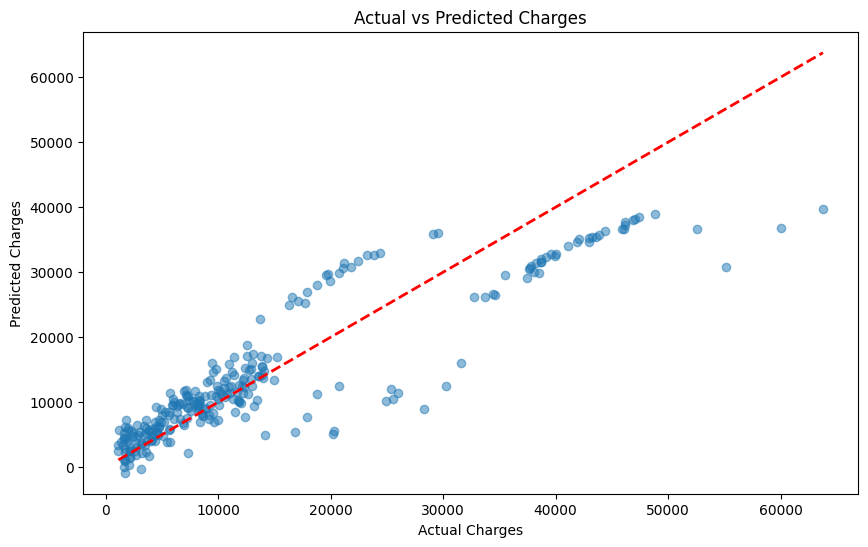

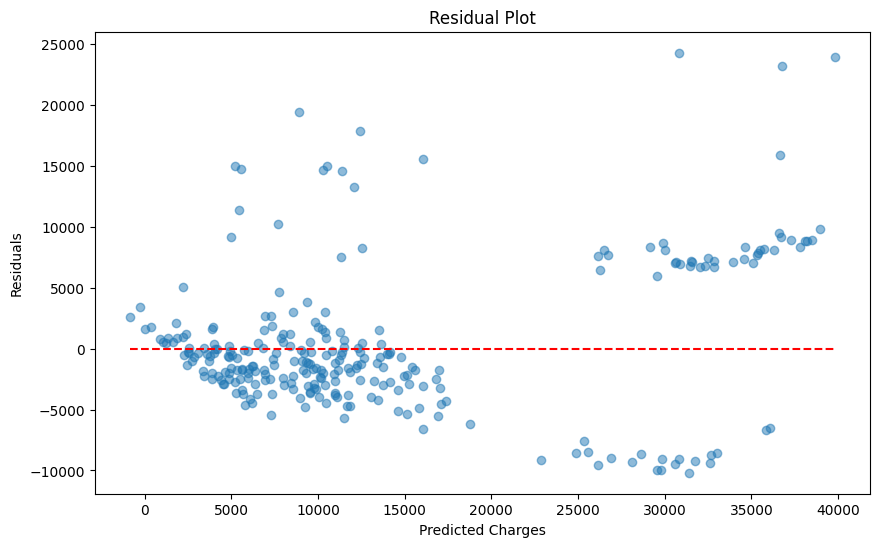

In [28]:
# Print feature coefficients
for feature, coef in zip(selected_features, model.coef_):
    print(f"{feature}: {coef}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.show()

# Plot residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='r', linestyles='--')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [29]:
X = sm.add_constant(X_train_scaled)

# Fit the model
model = sm.OLS(y_train, X)
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     409.3
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          3.13e-296
Time:                        10:42:44   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1061   BIC:                         2.172e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2293.3305    673.744     -3.404      0.0

In [30]:
residuos = results.resid
residuos.mean()

np.float64(-7.977008722004654e-12)

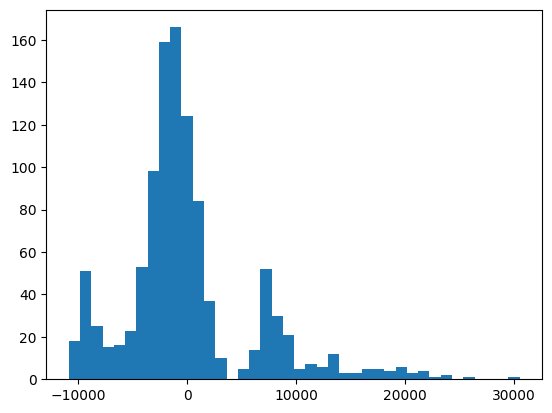

In [31]:
plt.hist(residuos, bins=40)
plt.show()

The model performs reasonably well, with smoking status, age, and BMI as key factors in predicting insurance charges. However, it struggles with high-cost predictions normally predicting under the expected price, indicating room for improvement.